# MNIST Dataset - Practice

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Load the dataset and explore

(28, 28, 1) 4


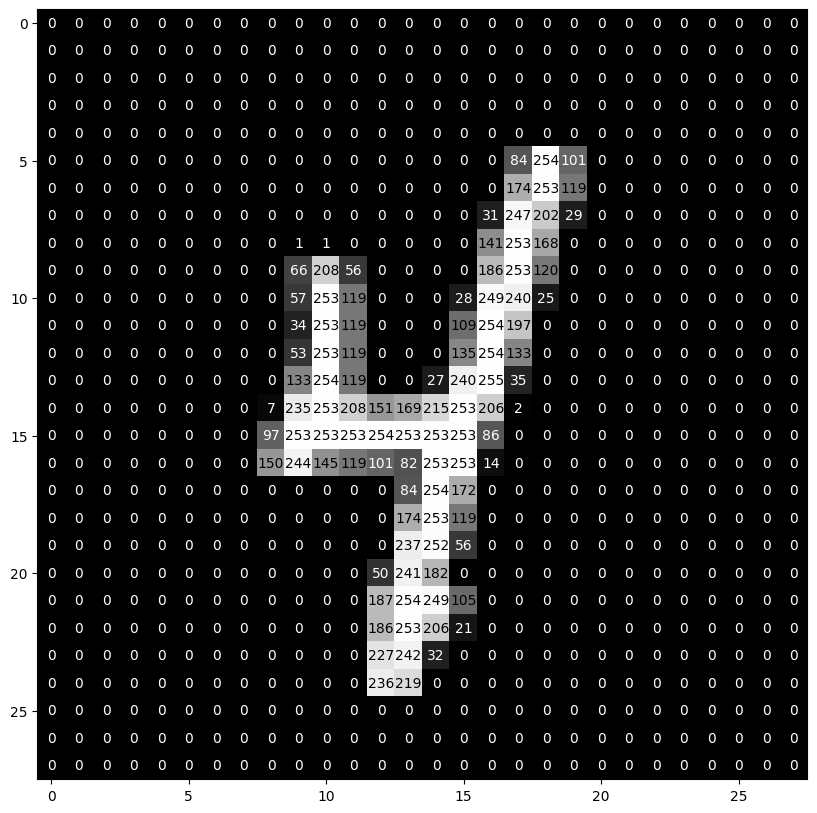

In [3]:
(train_ds, val_ds, test_ds), info = tfds.load('mnist', split=['train[:80%]', 'train[80%:]', 'test'], as_supervised=True, with_info=True)

example = train_ds.take(1)
for data in example:
    img = tfds.as_numpy(data[0])
    label = data[1]
    print(img.shape, tfds.as_numpy(label))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(data[0], cmap='gray', vmin=0, vmax=255)
    width, height, _ = img.shape
    tresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img[x][y][0]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if img[x][y][0] < tresh else 'k')



## Prepare the data for training

In [4]:
train_count = 0
val_count = 0
test_count = 0

for data in train_ds:
    train_count += 1

for data in val_ds:
    val_count += 1

for data in test_ds:
    test_count += 1

print("Train samples: ", train_count)
print("Validation samples: ", val_count)
print("Test samples: ", test_count)

Train samples:  48000
Validation samples:  12000
Test samples:  10000


In [5]:
BATCH_SIZE = 20
num_classes = 10

def preprocess(image, label):  # Turn each label value into 1D-arrays with zeros and a one at index=value
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def prepare_dataset(ds, shuffle=False):
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)  # Loads 1000 samples in-memory to be shuffled
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Fetch batches in the background. Automatically optimizes the number of parallel calls and prefetching

    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds)
test_ds = prepare_dataset(test_ds, shuffle=True)


## Build the convolutional neural network

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Rescaling(1. / 255))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,618 (861.79 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 192 (768.00 B)

## Train the model 

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="mnist.model.keras", save_best_only=True, verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

hist = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpointer, early_stopping, lr_scheduler], verbose=1, shuffle=True)

Epoch 1/50


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.7495 - loss: 0.7738 - val_accuracy: 0.9717 - val_loss: 0.0964 - learning_rate: 1.0000e-04
Epoch 2/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.9576 - loss: 0.1426 - val_accuracy: 0.9789 - val_loss: 0.0746 - learning_rate: 1.0000e-04
Epoch 3/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.9696 - loss: 0.1043 - val_accuracy: 0.9804 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 4/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.9746 - loss: 0.0863 - val_accuracy: 0.9852 - val_loss: 0.0524 - learning_rate: 1.0000e-04
Epoch 5/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9783 - loss: 0.0759 - val_accuracy: 0.9836 - val_loss: 0.0579 - learning_rate: 1.0000e-04
Epoch 6/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9803 - loss: 0.0683 - val_accuracy: 0.9862 - val_loss: 0.0503 - learning_rate: 1.0000e-04
Epoch 7/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/

## Visualize loss and accuracy

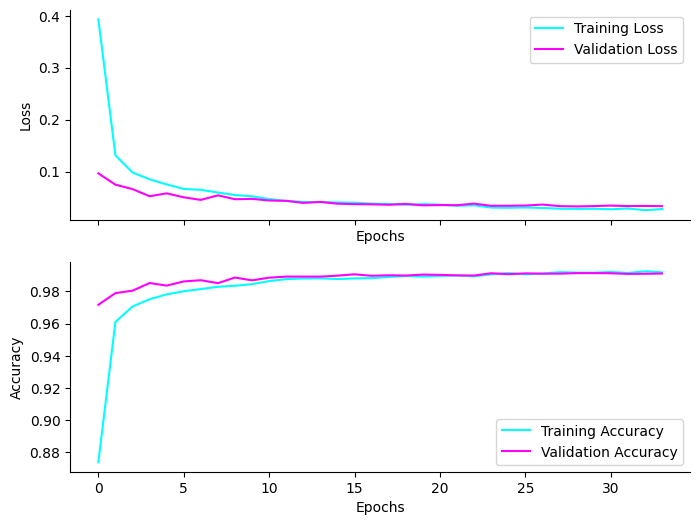

In [8]:
history = hist.history
plt.style.use('default')
# bg_color = '#000000'
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
# fig.patch.set_facecolor(bg_color)

# ax[0].set_facecolor(bg_color)
ax[0].plot(history['loss'], label='Training Loss', color='cyan')
ax[0].plot(history['val_loss'], label='Validation Loss', color='magenta')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# ax[1].set_facecolor(bg_color)
ax[1].plot(history['accuracy'], label='Training Accuracy', color='cyan')
ax[1].plot(history['val_accuracy'], label='Validation Accuracy', color='magenta')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    # a.spines["top"].set_visible(False)
    # a.spines["right"].set_visible(False)


## Load and evaluate the trained model

In [33]:
model = tf.keras.models.load_model('mnist.model.keras')
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

500/500 - 2s - 5ms/step - accuracy: 0.9924 - loss: 0.0238
Test loss: 0.0238
Test accuracy: 0.9924


# Conclusions

* The **mnist** was successfully loaded
* The use of 80% of the training data for training and 20% for validation seems to be appropriate
* After adding batch normalization, there was a slight increase in accuracy, from 98% to 99%
* The model seems to get overfitted after around 20 epochs (increase of validation loss observed)
* Early stopping is a good method since it automatically stops the process when validation loss starts to increase
* Learning rate reduction did not improved accuracy as expected
* Adding a dropout layer after flattening significantly improved the accuracy